<a href="https://colab.research.google.com/github/orzymandias/emotify-model/blob/master/emotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import the necessary packages

In [37]:
print("begining import...")
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras


# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text
from sklearn.model_selection import train_test_split


print("[+] Using Keras version",keras.__version__)


begining import...
[+] Using Keras version 2.3.0-tf




## Importing Data and Data Exploration
  



In [38]:
  CSV_DATA_URL = "https://raw.githubusercontent.com/orzymandias/emotify-model/master/data/data.csv"
  df = pd.read_csv(CSV_DATA_URL, names=["content", "sentiment"])
  df.head()

,content,sentiment
0,I hope all the Romo haters see how much we nee...,anger
1,When your boyfriend promised he'd take you for...,anger
2,The whole fucking team did their part EXCEPT K...,anger
3,@hannah_wootton @JessicaTidball @millyharrison...,anger
4,@CANDYCORNTIME and I never rap battled. #pissed,anger


#### Key Metrics of combined dataset
  * Number of samples: 48145
  * Number of classes: 4 (After merger)
  * Number of samples per class: (Shown under sentiment count)




In [39]:
df = df.drop_duplicates(subset=['content'], keep='first')  # remove duplicate data
df = df[(df.sentiment == "sadness") # filtering emotions of interest
    | (df.sentiment == "anger") 
    | (df.sentiment == "joy")
    | (df.sentiment == "happiness")
    | (df.sentiment == "fun") 
    | (df.sentiment == "fearful")
    | (df.sentiment == "fear") 
    | (df.sentiment == "hate")
    | (df.sentiment == "hate")
    | (df.sentiment == "empty")]
df = df.reset_index(drop=True)
print(df.shape)
df.head()

(48266, 2)


,content,sentiment
0,I hope all the Romo haters see how much we nee...,anger
1,When your boyfriend promised he'd take you for...,anger
2,The whole fucking team did their part EXCEPT K...,anger
3,@hannah_wootton @JessicaTidball @millyharrison...,anger
4,@CANDYCORNTIME and I never rap battled. #pissed,anger


#### Data Imbalance
We discover that we have an imbalanced dataset - there are overlapping categories and disproportional categories.




sadness      11014
anger         8958
fearful       8559
joy           8135
happiness     5184
fear          2498
fun           1775
hate          1322
empty          821
Name: sentiment, dtype: int64


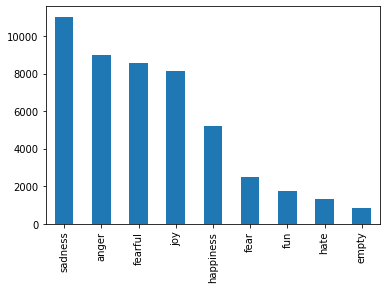

In [40]:
print(df.sentiment.value_counts())
df['sentiment'].value_counts().plot(kind='bar')


#### Actions to be taken:

*   Merge the happiness, joy and fun
*   Merge the anger and hate classes
*   Merge the sadness and empty classes
*   Merge the worry and fear classes
* Down-sampling the majority class ensure balance

In [41]:

df.dropna(inplace = True)
df["sentiment"] = df["sentiment"].replace({'empty': 'sadness', "hate": "anger","fun": "happiness",  "joy": "happiness", "fearful": "fear"})
print(df.sentiment.value_counts())


happiness    15094
sadness      11835
fear         11057
anger        10279
Name: sentiment, dtype: int64


#### Downsampling to achieve balance 

* Achieving balance is critical to ensure tha tt the model is not overtrained and overfits for a particular feature


In [42]:
happiness, worry, sadness, anger = df.sentiment.value_counts()
df_fear = df[df["sentiment"] == "fear"].sample(10000)
df_happiness = df[df["sentiment"] == "happiness"].sample(10000)
df_sadness = df[df["sentiment"] == "sadness"].sample(10000)
df_anger = df[df["sentiment"] == "anger"].sample(10000)
df = pd.concat([df_fear, df_happiness, df_sadness, df_anger], axis=0)

df.reset_index(drop=True, inplace=True)
print(df.sentiment.value_counts())


fear         10000
sadness      10000
anger        10000
happiness    10000
Name: sentiment, dtype: int64


### Key Metrics of usable dataset
  * Number of samples: 40,000
  * Number of classes: 4
  * Number of samples per class: 4000/5000
  * Median words per sample: 14
  * Samples/words-per-sample ratio: 1357 (borderline 1500)

In [43]:
def get_num_words_per_sample(sample_texts):
    """Returns the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)
print("\n\nMedian number of words per sample: ", get_num_words_per_sample(df['content']))




Median number of words per sample:  14.0


## Preprocessing and Data Cleaning






#### Encoding Emotions to Ids

* 0 - anger  
* 1 - fear
* 2 - happiness
* 3 - sadness



In [44]:
df['sentiment'] = pd.Categorical(df['sentiment'])
df['sentiment'] = df.sentiment.cat.codes
df.head(17888)

,content,sentiment
0,you gotta get a lil rowdy for the fsu and gato...,1
1,to live a creative we must lose our of being #...,1
2,#TERRIFIED @10!!!,1
3,I don’t even want to talk about it. #terrified,1
4,Gleich muss ich als Volti Papa auch aufs Pferd...,1
...,...,...
17883,@katehughes So what do you do when you wake up...,2
17884,"Big day of school ahead of me, it's that group...",2
17885,"Time for bed, finally (: :/",2
17886,"thelma &amp; louise, Good movie.",2


#### Clean tweets



In [45]:
!pip install tweet-preprocessor
import preprocessor as p
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [46]:
from nltk.corpus import stopwords

print(df.content.head(10))
def clean_sentence(sentence):
    # removing handles and links
    sentence = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",sentence).split())

    # removing stopwords
    # stop_words = list(stopwords.words('english'))   
    # sentence = " ".join([word.lower() for word in sentence.split() if word not in (stop_words)])   
    sentence = " ".join([word.lower() for word in sentence.split()])   
    
    p.set_options(p.OPT.URL, p.OPT.EMOJI)
    return p.clean(sentence)


df['content'] = df['content'].map(lambda x: clean_sentence(x))

print("-------------------- After cleaning--------------------")
print(df.content.head(10))
    

0    you gotta get a lil rowdy for the fsu and gato...
1    to live a creative we must lose our of being #...
2                                   #TERRIFIED @10!!! 
3       I don’t even want to talk about it. #terrified
4    Gleich muss ich als Volti Papa auch aufs Pferd...
5    Shit. No no no please no! #scared #terrified #...
6    Factor tweetRT @BeautiiFades This looks disgus...
7    @RalphVenuto so I just turned on my tv and wou...
8    People Who Are #Intimidated By You Talk Bad Ab...
9    MADD encourages safety on the road on Hallowee...
Name: content, dtype: object
-------------------- After cleaning--------------------
0    you gotta get a lil rowdy for the fsu and gato...
1    to live a creative we must lose our of being w...
2                                            terrified
3         i don t even want to talk about it terrified
4    gleich muss ich als volti papa auch aufs pferd...
5    shit no no no please no scared terrified nosui...
6    factor tweetrt this looks disg

#### Spliting training and test set




In [47]:
sentiment = df.pop("sentiment")
content = df

x_train, y_train, x_test, y_test = train_test_split(content, sentiment, test_size=0.20, shuffle=True, random_state=42)
print(" Training: size", x_train.shape[0])
print(" Validation size:",y_train.shape[0])
training_data, validation_data, training_label, validation_label = np.array(x_train.content), np.array(y_train.content), np.array(x_test), np.array(y_test)



 Training: size 32000
 Validation size: 8000


#### Model Parameters

In [0]:
TOP_K = 10000
MAX_SEQUENCE_LENGTH = 28
num_classes = 4


#### Tokenization and Vectorization

* Tokenizes the texts into words
* Creates a vocabulary using the top 20,000 tokens
* Converts the tokens into sequence vectors
* Pads the sequences to a fixed sequence length


In [49]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
def sequence_vectorize(train_texts, val_texts):
   
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)
    print("tokenizer", train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)
    print("training_data_vectorized", x_train)
    print("validation_data_vectorized", x_val)

    # Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH)
    x_val = sequence.pad_sequences(x_val, maxlen=MAX_SEQUENCE_LENGTH)
    return x_train, x_val, tokenizer.word_index

training_data_vectorized, validation_data_vectorized, word_index = sequence_vectorize(training_data,validation_data)
print(training_data_vectorized[0].shape)

tokenizer ['it s simple for those who know how to use it hahaa i m glad you re okay x x x'
 'nice to see you tweeting it s sunday 10th may and we re celebrating mother s day here today so be nice to yer mom'
 'ah lets start working livingroom here i come' ...
 'just tripped over cooler and there is beer in my hair pissed'
 'watched for the first time last night reesewitherspoon and markwallburg a great performance'
 'it was amazing had the best time hope you had a good weekend too']
training_data_vectorized [[10, 17, 1380, 12, 238, 103, 74, 67, 3, 451, 10, 5396, 1, 23, 526, 7, 98, 566, 396, 396, 396], [241, 3, 90, 7, 1268, 10, 17, 446, 6312, 298, 5, 43, 98, 2459, 400, 17, 40, 124, 50, 20, 24, 241, 3, 3853, 253], [800, 1224, 251, 244, 9749, 124, 1, 157], [1104, 3, 90, 6, 822, 26, 2, 1764, 77, 2331, 104, 154, 494], [11, 566, 94, 2460, 114, 717, 4734, 537, 265], [70, 3, 3272, 67, 6, 2046, 496, 1105, 1603, 16, 70, 3272, 2046, 496, 1105, 1603], [1268], [24, 1, 531, 2, 2461, 661, 254, 18, 4,

## Model

###Model 1: sepCNN
  * Tensorflow documentation

### Model 2: CNN

* loss: 0.8516 - acc: 0.6304 - val_loss: 0.8652 - val_acc: 0.6229
* loss: 0.8539 - acc: 0.6303 - val_loss: 0.8567 - val_acc: 0.6270

In [50]:
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers

from keras import models
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer

def cnn_Model(dropout_rate, num_classes):
    model = models.Sequential()
    model.add(Embedding(TOP_K + 1,
                        50,
                        input_length=MAX_SEQUENCE_LENGTH))
    model.add(Dropout(dropout_rate))
    model.add(Conv1D(64,
                     4,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(256))
    model.add(Dropout(dropout_rate))
    model.add(Activation('relu'))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(num_classes, activation="sigmoid"))
    # model.add(Dense(num_classes, activation="softmax"))
    model.summary()

    return model



model = cnn_Model(num_classes=num_classes, dropout_rate=0.2)


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 28, 50)            500050    
_________________________________________________________________
dropout_11 (Dropout)         (None, 28, 50)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 25, 64)            12864     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
activation_4 (Activation)    (None, 256)              

###Model 3: RNN LSTM Model
* Performance
  * loss: 0.8149 - acc: 0.6585 - val_loss: 0.8769 - val_acc: 0.6173
  * loss: 0.8156 - acc: 0.6591 - val_loss: 0.8729 - val_acc: 0.6227



In [51]:
from keras import models
from keras.layers import Embedding, Dense, LSTM, Dropout, SpatialDropout1D

def lstm_RNN(num_classes, dropout_rate):
    model = models.Sequential()
    model.add(Embedding(TOP_K,
                        200,
                        input_length=MAX_SEQUENCE_LENGTH))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(50, dropout=dropout_rate, recurrent_dropout=0.3))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation="softmax"))
    model.summary()
    return model

model = lstm_RNN(4, 0.2)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 28, 200)           2000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 28, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                50200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 204       
Total params: 2,050,404
Trainable params: 2,050,404
Non-trainable params: 0
_________________________________________________________________



### Model 4: Pretrained Embedded Model with MLP
* Performance
  * loss: 0.9027 - acc: 0.6317 - val_loss: 1.0744 - val_acc: 0.5468





* Import TFhub

In [0]:
!pip install -q tensorflow-hub



In [53]:
from keras import models
import tensorflow_hub as hub
import tensorflow_datasets as tfds

embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

def transferEmbedding(layers, units, dropout_rate, num_classes):
  model = tf.keras.Sequential()
  model.add(hub_layer)

  for _ in range(layers-1):
        model.add(tf.keras.layers.Dense(units=units, activation='relu'))
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))
        model.add(tf.keras.layers.Dense(num_classes, activation="softmax"))
        # model.add(tf.keras.layers.Dense(num_classes, activation="sigmoid"))

  model.summary()
  return model

model = transferEmbedding(3, 32, 0.3, 2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 20)                400020    
_________________________________________________________________
dense_5 (Dense)              (None, 32)                672       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 66        
_________________________________________________________________
dense_7 (Dense)              (None, 32)                96        
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                

### Model 5: RNN LSTM2
  * 0.7894 - acc: 0.6669 - val_loss: 0.8719 - val_acc: 0.6285

In [54]:
def RNN_LSTM2(dropout_rate):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(TOP_K, 200, input_length=training_data_vectorized.shape[1]))
  model.add(tf.keras.layers.SpatialDropout1D(dropout_rate))
  model.add(tf.keras.layers.LSTM(50, dropout=dropout_rate, recurrent_dropout=0.2))
  model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
  model.summary()
  return model

RNN_LSTM2(0.2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 28, 200)           2000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 28, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                50200     
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 204       
Total params: 2,050,404
Trainable params: 2,050,404
Non-trainable params: 0
_________________________________________________________________


### Hyperparameters

In [0]:
learning_rate = 1e-4
batch_size = 64
epochs =20
dropout_rate=0.2
kernel_size = 3


In [56]:
'''
  To save model to your drive
  Set checkpoint_path accordingly drive/My Drive/xxx
'''
from google.colab import drive
import os
drive.mount('/content/drive')
checkpoint_path = "/content/model/"
checkpoint_dir = os.path.dirname(checkpoint_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Training

* https://ruder.io/optimizing-gradient-descent/

In [57]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau

# Initlize Model
model = cnn_Model(num_classes=num_classes, dropout_rate=dropout_rate)
# model = lstm_RNN(num_classes=num_classes, dropout_rate=dropout_rate)
# model = transferEmbedding(layers=2, units=64, dropout_rate=dropout_rate, num_classes=num_classes)
# model = RNN_LSTM2(dropout_rate=dropout_rate)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint(filepath = checkpoint_path + 'my_model.h5', 
    verbose=1, save_best_only=True, save_weights_only=False) 
    ]
        

# model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['acc'])
# model.compile(optimizer="adadelta", loss='sparse_categorical_crossentropy', metrics=['acc'])
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['acc'])

# Fit Model
# remember to switch training data depending on model
history = model.fit(
            training_data_vectorized,
            training_label,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(validation_data_vectorized, validation_label),
            verbose=1,  # Logs once per epoch.
            batch_size=batch_size)


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 28, 50)            500050    
_________________________________________________________________
dropout_15 (Dropout)         (None, 28, 50)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 25, 64)            12864     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
activation_5 (Activation)    (None, 256)              

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 32000 samples, validate on 8000 samples
Epoch 1/20
32000/32000 [==============================] - 7s 226us/step - loss: 0.7891 - acc: 0.6535 - val_loss: 0.5812 - val_acc: 0.7656

Epoch 00001: val_loss improved from inf to 0.58116, saving model to /content/model/my_model.h5
Epoch 2/20
32000/32000 [==============================] - 7s 214us/step - loss: 0.5097 - acc: 0.8002 - val_loss: 0.5727 - val_acc: 0.7763

Epoch 00002: val_loss improved from 0.58116 to 0.57274, saving model to /content/model/my_model.h5
Epoch 3/20
32000/32000 [==============================] - 7s 223us/step - loss: 0.4022 - acc: 0.8496 - val_loss: 0.5991 - val_acc: 0.7742

Epoch 00003: val_loss did not improve from 0.57274
Epoch 4/20
32000/32000 [==============================] - 7s 209us/step - loss: 0.3148 - acc: 0.8875 - val_loss: 0.6439 - val_acc: 0.7620

Epoch 00004: val_loss did not improve from 0.57274
Epoch 00004: early stopping


Plot loss graph

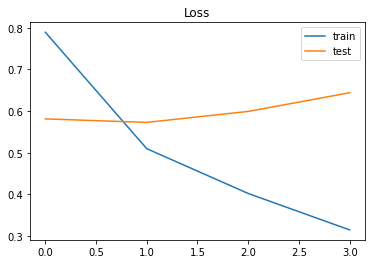

In [58]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

## Model Evaluation

In [59]:
loss,acc = model.evaluate(validation_data_vectorized,  validation_label, verbose=2)
print("model accuracy: {:5.2f}% \nmodel loss {:5.2f}".format(100*acc, loss))


model accuracy: 76.20% 
model loss  0.64


### Classification Report and Confusion Matrix

              precision    recall  f1-score   support

       anger       0.79      0.81      0.80      2000
        fear       0.92      0.89      0.90      2047
   happiness       0.66      0.75      0.70      1967
     sadness       0.69      0.60      0.64      1986

    accuracy                           0.76      8000
   macro avg       0.76      0.76      0.76      8000
weighted avg       0.76      0.76      0.76      8000



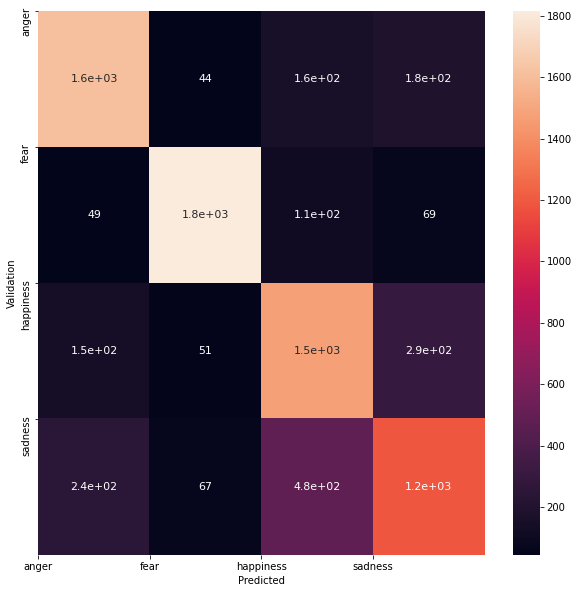

In [60]:
 from sklearn.metrics import classification_report, confusion_matrix
 import seaborn as sn


#  labels = ["anger", "happiness", "sadness","worry"]
 labels = ["anger", "fear", "happiness", "sadness"]

 predictions = model.predict(validation_data_vectorized)
 predictions = np.argmax(predictions,axis=1)

print(classification_report(validation_label, predictions, target_names=labels))


matrix = confusion_matrix(validation_label, predictions)
plt.figure(figsize=(10,10))
sn.heatmap(matrix, annot=True, annot_kws={"size": 11}) # font size
plt.xlabel('Predicted')
plt.ylabel('Validation')
plt.xticks(np.arange(4), labels)
plt.yticks(np.arange(4), labels)

plt.show()

In [62]:
from tensorflow.python.keras.preprocessing import text

def tokenize_and_pad(input):
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(training_data)
    tokenized = tokenizer.texts_to_sequences(input)
    padded = sequence.pad_sequences(tokenized, maxlen=MAX_SEQUENCE_LENGTH)
    return padded

def predict_emo(input):
    encoded = tokenize_and_pad([input])
    return model.predict(encoded)

'''
  non transfer learning models
  labels = ["anger", "fear", "happiness", "sadness"]
'''
emotion = np.argmax(predict_emo("he's so scary"))
print(f"Predicted emotion: {labels[emotion]}")

emotion = np.argmax(predict_emo("I am over the moon"))
print(f"Predicted emotion: {labels[emotion]}")

emotion = np.argmax(predict_emo("dont hurt me"))
print(f"Predicted emotion: {labels[emotion]}")

emotion = np.argmax(predict_emo("I hate you"))
print(f"Predicted emotion: {labels[emotion]}")

# transfer learning model
# model.predict(["I am in pain"])


Predicted emotion: fear
Predicted emotion: happiness
Predicted emotion: sadness
Predicted emotion: anger


### Save Model
